In [7]:
import gzip
import numpy as np
import pandas as pd
import scipy.optimize
import random
from collections import defaultdict
import nltk
from sklearn import svm
import string
from sklearn import linear_model
import pickle

In [8]:
def parseData(fname):
  for l in open(fname):
    yield eval(l)
data = [d for d in parseData("train.json")]

In [9]:
reviews = [d['reviewText'] for d in data]
y = [d['categoryID'] for d in data]

In [267]:
categories = [[] for d in range(5)]
for d in data:
    categories[d['categoryID']].append(d)

In [3]:
import torch

In [321]:
import numpy as np
def loadGloveModel(gloveFile):
    f = open(gloveFile,'r', encoding='utf-8')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model
import gensim
s= []
for d in data:
    r = ''.join([c.lower() for c in d['reviewText']])
    sentences = r.split('.')
    for sentence in sentences:
        words = []
        for w in sentence.split():
            words.append(w)
        s.append(words)

model = gensim.models.Word2Vec(
        s,
        size=100,
        window=10,
        min_count=0)
model.train(s, total_examples=len(s), epochs=10)

(86423538, 119249800)

In [5]:
glove = loadGloveModel('glove300.txt')

Done. 400000  words loaded!


In [42]:
X_train = np.array(X[:100000])
X_test = np.array(X[100000:])
y_train = np.array(y[:100000])
y_test = np.array(y[1000000:])

In [322]:
def review_to_tensor(review):
    punctuation = set(string.punctuation)
    x = []
    r = ''.join([c for c in review.lower() if not c in punctuation])
    r = r.split()
    for word in r:
        if word not in glove:
            r.remove(word)
    tensor = torch.zeros(len(r), 1, 100)
    for li, word in enumerate(r):
        if word in model:
            tensor[li][0] = torch.from_numpy(model[word])
    return tensor

In [334]:
import torch.nn as nn
n_categories = 5
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
class LSTM(nn.Module):

    def __init__(self, hidden_dim):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(100, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2out = nn.Linear(hidden_dim, 5)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, input):
        lstm_out, self.hidden = self.lstm(input, self.hidden)
        out = self.hidden2out(self.hidden)
        out = F.log_softmax(out, dim=1)
        return out

n_hidden = 100
rnn = RNN(100, n_hidden, 5)

In [335]:
# One-hot vector for category
def categoryTensor(category):
    tensor = torch.zeros(1, 5)
    tensor[0][category] = 1
    return tensor

input = review_to_tensor(reviews[3])
hidden = torch.zeros(1, n_hidden)
category = categoryTensor(y[3])
output, next_hidden = rnn(input[0], hidden)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [336]:
review_to_tensor(reviews[73959])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


tensor([[[ 6.5831,  4.2803, -4.4527,  ...,  0.7554, -0.4660, -2.0357]],

        [[ 4.4599, -2.3481, -0.8871,  ...,  5.3055, -0.4463,  5.2171]],

        [[ 4.8540,  3.0677, -0.8828,  ..., -3.0054,  0.3446, -1.2148]],

        ...,

        [[ 0.3005, -3.7607,  1.5351,  ..., -3.4989, -1.5394,  1.2987]],

        [[ 3.5993,  3.1479, -2.3967,  ...,  0.2867, -2.6979, -2.1864]],

        [[-1.7778,  2.3472,  0.1473,  ...,  0.4434,  0.6594, -6.2985]]])

In [337]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return category_i
categoryFromOutput(output)
output

tensor([[-1.3889, -1.4541, -1.7246, -1.8057, -1.7461]], grad_fn=<LogSoftmaxBackward>)

In [338]:
criterion = nn.NLLLoss()

In [339]:
learning_rate = 0.0001 # If you set this too high, it might explode. If too low, it might not learn

def train(line_tensor, hidden, ct):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, ct)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, hidden, loss.item()

In [340]:
def randomTrainingExample():
    i = random.randint(0,len(reviews)-1)
    category = y[i]
    line = reviews[i]
    line_tensor = review_to_tensor(reviews[i])
    if len(line_tensor) == 0:
        return randomTrainingExample()
    category_tensor = categoryTensor(category)
    ct = torch.tensor([category], dtype=torch.long)
    return category, line, category_tensor, line_tensor, ct
randomTrainingExample()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


(0,
 'I LOVE these beautiful earrings. I wanted something for that 2nd hole up higher on my ear lobe. I wanted something large enough to be seen and add a little color to my pale complexion. These are just what I wanted!',
 tensor([[1., 0., 0., 0., 0.]]),
 tensor([[[ 4.1525,  0.2597,  0.4140,  ..., -0.9523, -2.6033, -1.6936]],
 
         [[-1.3386, -0.9493,  3.4099,  ..., -2.0856, -2.7873, -2.5723]],
 
         [[-2.1854, -0.7062, -1.3682,  ..., -2.4345,  3.0724, -2.1045]],
 
         ...,
 
         [[ 1.3475, -1.5548, -1.2212,  ...,  3.4966, -2.6836, -1.3082]],
 
         [[ 4.1525,  0.2597,  0.4140,  ..., -0.9523, -2.6033, -1.6936]],
 
         [[ 2.5461, -0.7319,  0.5716,  ..., -1.2392, -1.3994,  0.9284]]]),
 tensor([0]))

In [341]:
import time
import math
import random
n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor, ct = randomTrainingExample()
    output, hidden, loss = train(line_tensor, hidden, ct)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


5000 5% (1m 6s) 0.3788 I have never worn crocs before, so I'm not sure I'm the best to review these.  They were very sloppy and oversized and I normally wear a size 9M. / 0 ✓
10000 10% (2m 11s) 4.5784 The flower is larger (but not too large, like some of the baby satellite antennae available out there) than I thought it would be and is much much prettier.  I expected to like it but I love it.  Love it! / 0 ✗ (4)
15000 15% (3m 15s) 0.2901 This is a very comfortable shoe. It has several cutouts that make it more like a sandal. The photo does not show al of the cutouts. It was only after I saw this shoe at a store that I realized how like a fisherman's sandal it was.  I guess Clark's is not using the Privo Brand so much now, but this is a Privo type shoe and has the little bumps in the insole like the Privos did.I was pleased to see how many colors are available and plan to order another pair. The only downside on some colors is that the elastic straps are not a perfect match for the leat

100000 100% (20m 47s) 0.7103 Very good quality, very nice fit.  Reviews that other buyers posted were very helpful.  In fact, the reviews are what I go by, not just the product description.  They tell you pretty much everything you need to know, and there are no surprises. / 0 ✓


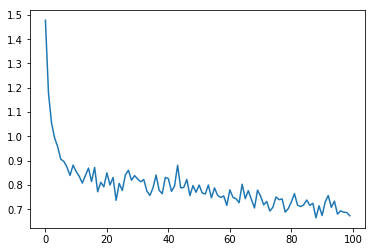

In [346]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [289]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    output = []
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output
evaluate(review_to_tensor(reviews[1]))

tensor([[-0.3955, -1.3778, -6.7090, -2.6287, -6.7912]], grad_fn=<LogSoftmaxBackward>)

In [290]:
def readGz(f):
    for l in gzip.open(f):
        yield eval(l)
        
predictions = open("rnn_prediction_category1.txt", 'w')
predictions.write("reviewerID-reviewHash,category\n")
for l in readGz("test_Category.json.gz"):
    with torch.no_grad():
        output = evaluate(review_to_tensor(l['reviewText']))
    if len(output) == 0:
        cat = 0
    else:
        cat = categoryFromOutput(output)
    predictions.write(l['reviewerID'] + '-' + l['reviewHash'] + "," + str(cat) + "\n")

predictions.close()

In [345]:
predictions = []
for l in data[:20000]:
    with torch.no_grad():
        output = evaluate(review_to_tensor(l['reviewText']))
        if len(output) == 0:
            cat = 0
        else:
            cat = categoryFromOutput(output)
    predictions.append(cat)
correct = [(a==b) for (a,b) in zip(predictions, y[:20000])]
print(np.sum(correct)/len(predictions))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


0.72775
